# benchmarking a Model's Performance - Plotting MAE vs. Fetal Depth in 3 Sections

In [6]:
# Load model + Scalers + Data
import joblib
from pathlib import Path
import torch
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from inverse_modelling_tfo.model_training.custom_models import PerceptronBD
from inverse_modelling_tfo.misc.misc_training import set_seed

## Load Data
file_name = "pulsation_ratio_interp_sd3_5wv"
PROJECT_BASE_PATH = Path().resolve().parent.parent
data = pd.read_pickle(PROJECT_BASE_PATH / "data" / "processed_data" / f"{file_name}.pkl")
data["Fetal Depth"] = data["Maternal Wall Thickness"] + 6.0
data = data.copy()      # Break fragmentation

# Load Configs
CONFIG_PATH = PROJECT_BASE_PATH / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r", encoding="utf8") as f:
    config = json.load(f)
labels = config["labels"]
all_features = config["features"]

/tmp/ipykernel_3422506/834682753.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Fetal Depth"] = data["Maternal Wall Thickness"] + 6.0


In [7]:
from model_trainer import ColumnBasedRandomSplit
import matplotlib.pyplot as plt
import numpy as np 

models_to_try = ['random_split_2wv_40_features', 'random_split_3wv_60_features', 'random_split_4wv_80_features', 'random_split_5wv_100_features']
model_labels = ['Two Wavelength', 'Three Wavelength', 'Four Wavelength', 'Five Wavelength']
model_wavelengths = [       # PS: Don't change this ordering - this needs to match the order during training!
    [850.0, 735.0],
    [850.0, 735.0, 810.0],
    [690.0, 850.0, 735.0, 810.0],
    [910.0, 690.0, 850.0, 735.0, 810.0],
]
input_layer_shapes = [40, 60, 80, 100]
wavelength_to_feature_map = {  # Which features correspond to which wavelengths - (forgot to sort before creating the features)
        910.0: all_features[:20],
        690.0: all_features[20:40],
        850.0: all_features[40:60],
        735.0: all_features[60:80],
        810.0: all_features[80:100],
    }

mae_value_matrix = []
mae_std_matrix = []

for model_name, model_label, model_wavelengths, input_layer_shape in zip(models_to_try, model_labels, model_wavelengths, input_layer_shapes):
    model = PerceptronBD([input_layer_shape, 80, 40, 1])   # Create Model Here -> This cannot be auto loaded!

    model_weights = torch.load(PROJECT_BASE_PATH / "models" / f"{model_name}.pt", weights_only=True)
    model.load_state_dict(model_weights)
    x_scaler = joblib.load(PROJECT_BASE_PATH / "models" / f"{model_name}_xscaler")
    y_scaler = joblib.load(PROJECT_BASE_PATH / "models" / f"{model_name}_yscaler")
    # Data Pre-processing
    features = [feature for wavelength in model_wavelengths for feature in wavelength_to_feature_map[wavelength]]

    y_columns = ["Fetal Saturation"]
    x_columns = features 
    print()
    
    validation_method = ColumnBasedRandomSplit('Fetal Depth', 0.8, seed=40)
    train_data, val_data = validation_method.split(data)

    filter_by_column = "Fetal Depth"

    # Plot the MAE for each filter_by_column
    all_filter_values = data[filter_by_column].unique()
    all_filter_values.sort()

    model = model.eval()
    model = model.cuda()
    mae_values = []
    mae_std = []
    for filter_value in all_filter_values:
        # val_data = val_data[val_data[filter_by_column] == filter_value]
        val_data = data[data[filter_by_column] == filter_value]
        x_val = x_scaler.transform(val_data[x_columns])
        y_pred = model(torch.tensor(x_val, dtype=torch.float32).cuda()).detach().cpu().numpy()
        y_pred = y_scaler.inverse_transform(y_pred)     # Scale back to original
        y_val = val_data[y_columns].values      # Unscaled
        mae = np.mean(np.abs(y_pred - y_val))
        std = np.std(np.abs(y_pred - y_val))
        mae_values.append(mae)
    mae_std.append(std)
    
    ## Store the values to the matrix
    mae_value_matrix.append(mae_values)
    mae_std_matrix.append(mae_std)

mae_value_matrix = np.array(mae_value_matrix)
mae_std_matrix = np.array(mae_std_matrix)

## Plotting

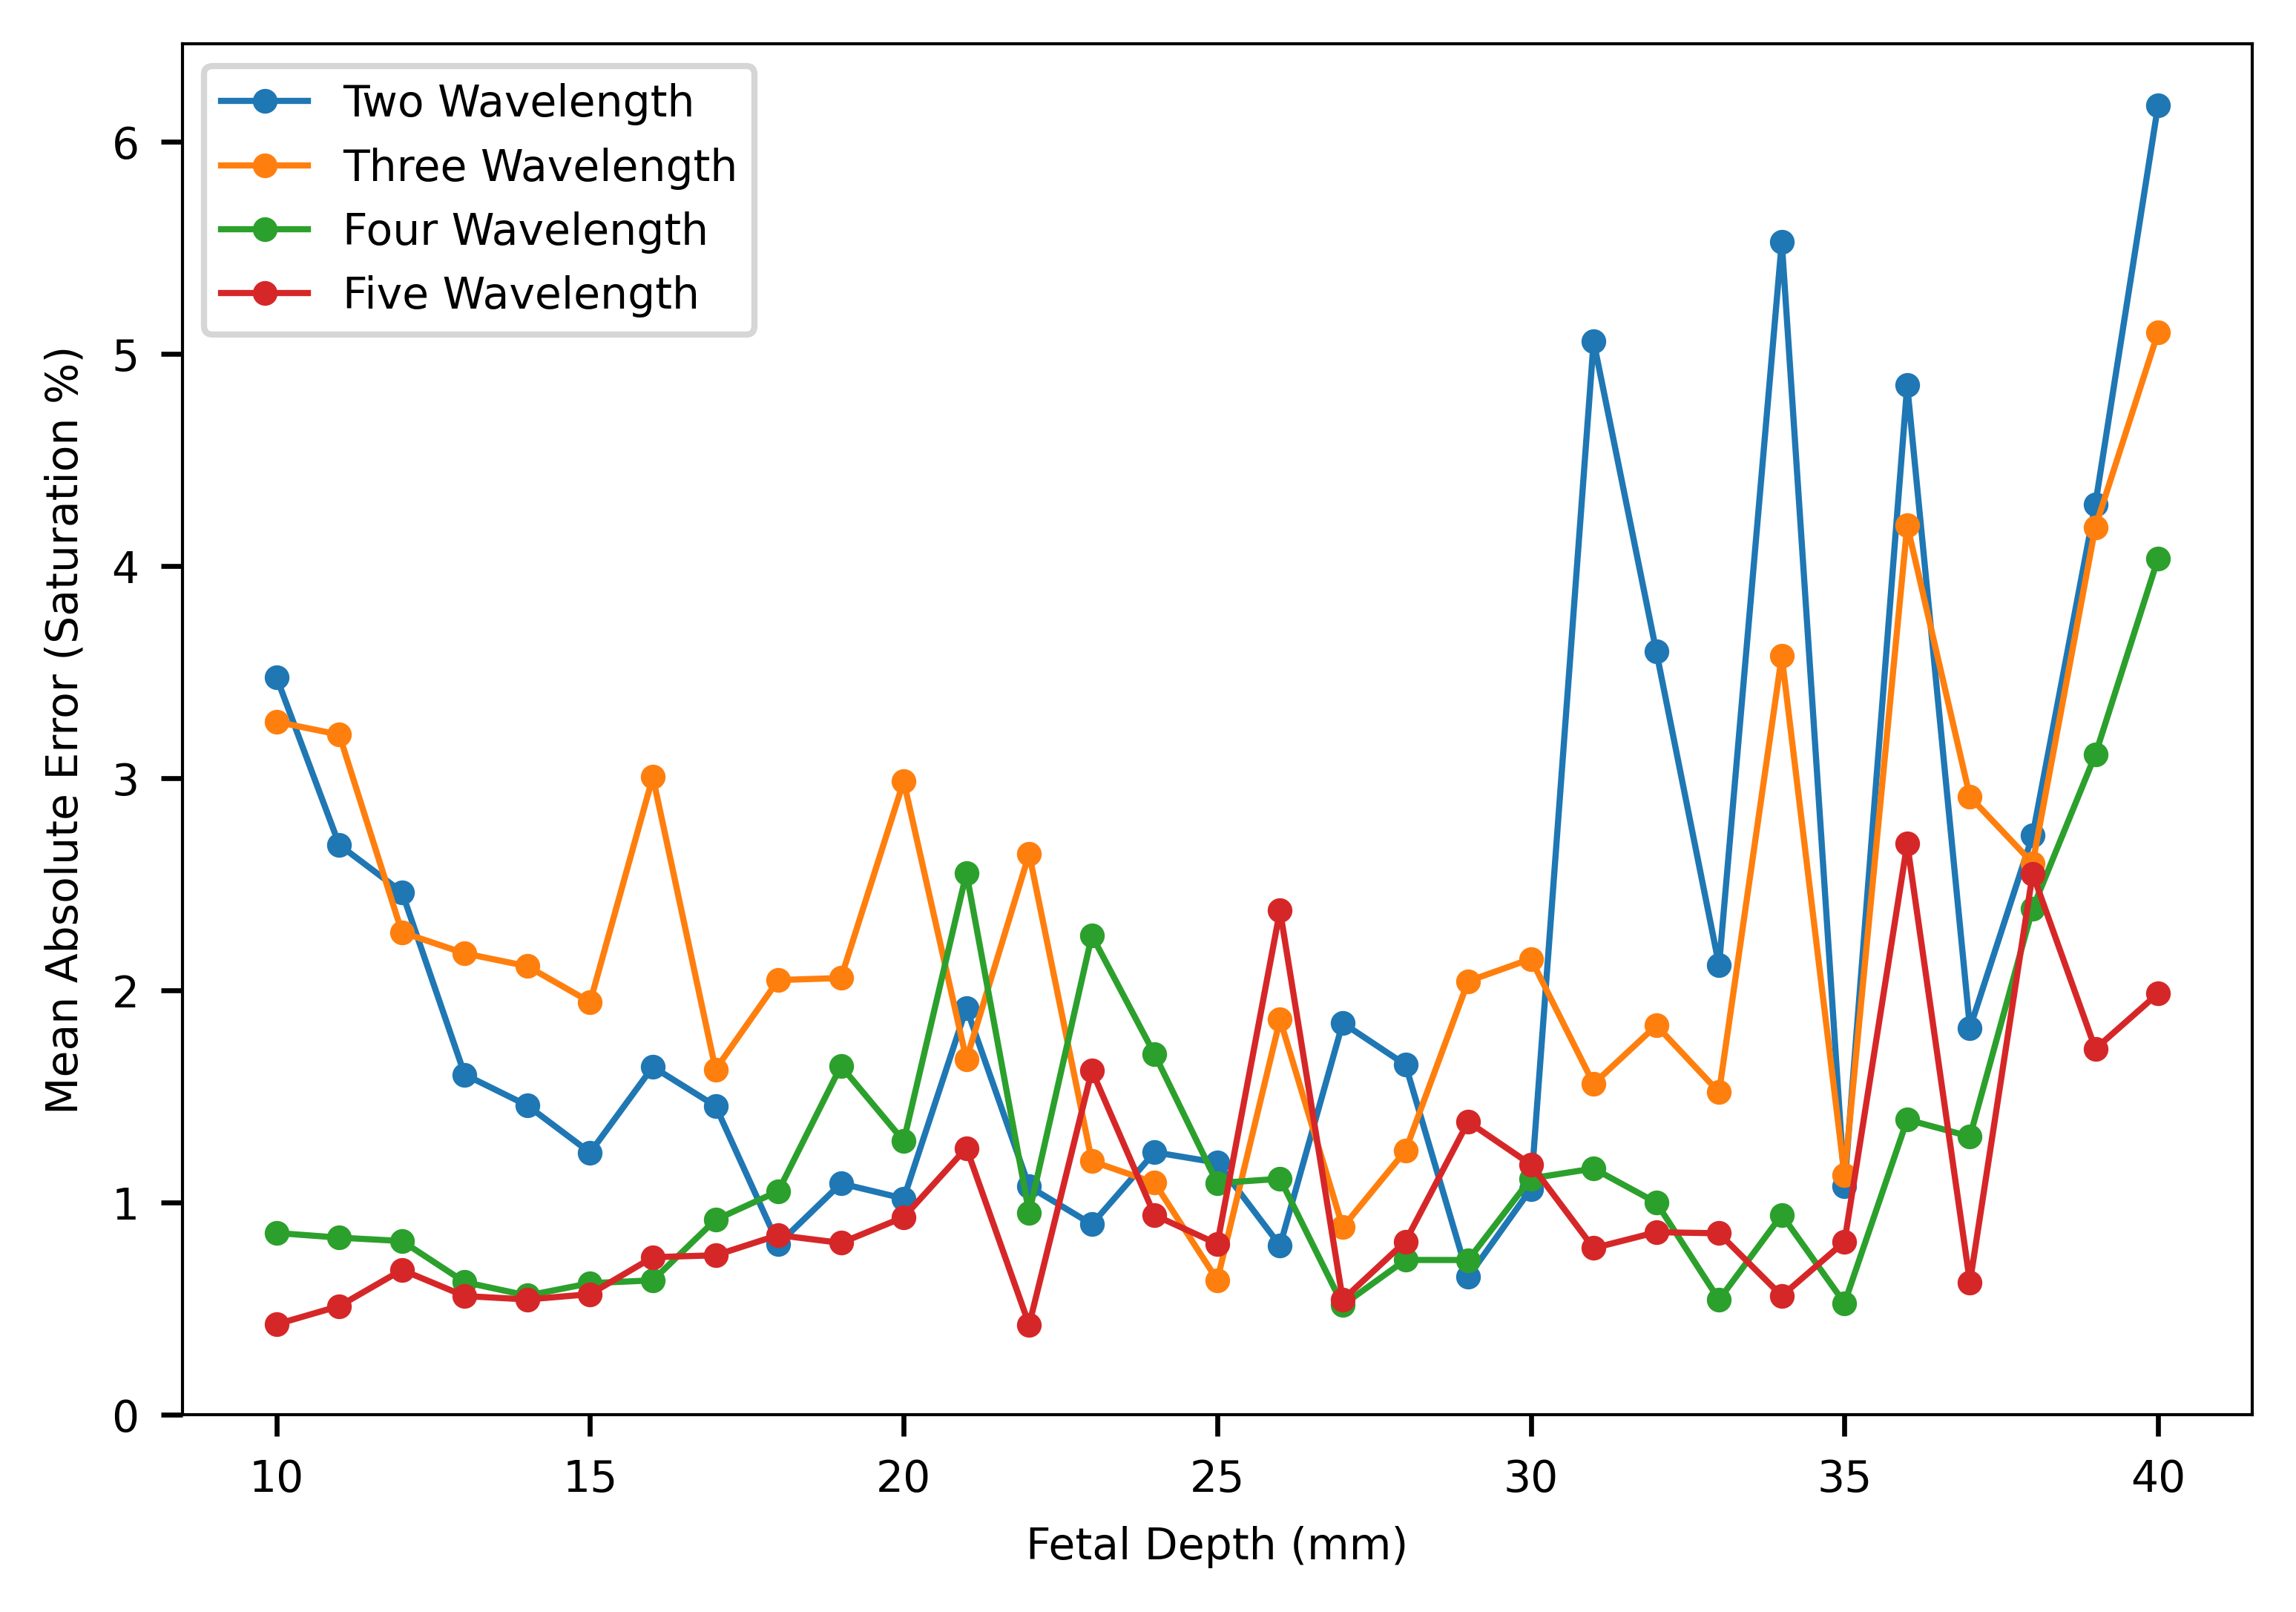

In [8]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('nature')
plt.figure(figsize=(6, 4), dpi=600)
for mae_values, mae_std, model_label in zip(mae_value_matrix, mae_std_matrix, model_labels):
    # plt.errorbar(all_filter_values, mae_values, yerr=mae_std, label=model_label)
    plt.plot(all_filter_values, mae_values * 100, label=model_label, marker='o')    # Convert to percentage

# Make the lower limit 0
plt.ylim(bottom=0)

plt.xlabel("Fetal Depth (mm)")
plt.ylabel("Mean Absolute Error (Saturation %)")
plt.legend()

Text(0.5, 1.0, 'MAE(Across All Fetal Depths) Improve With More Wavelengths')

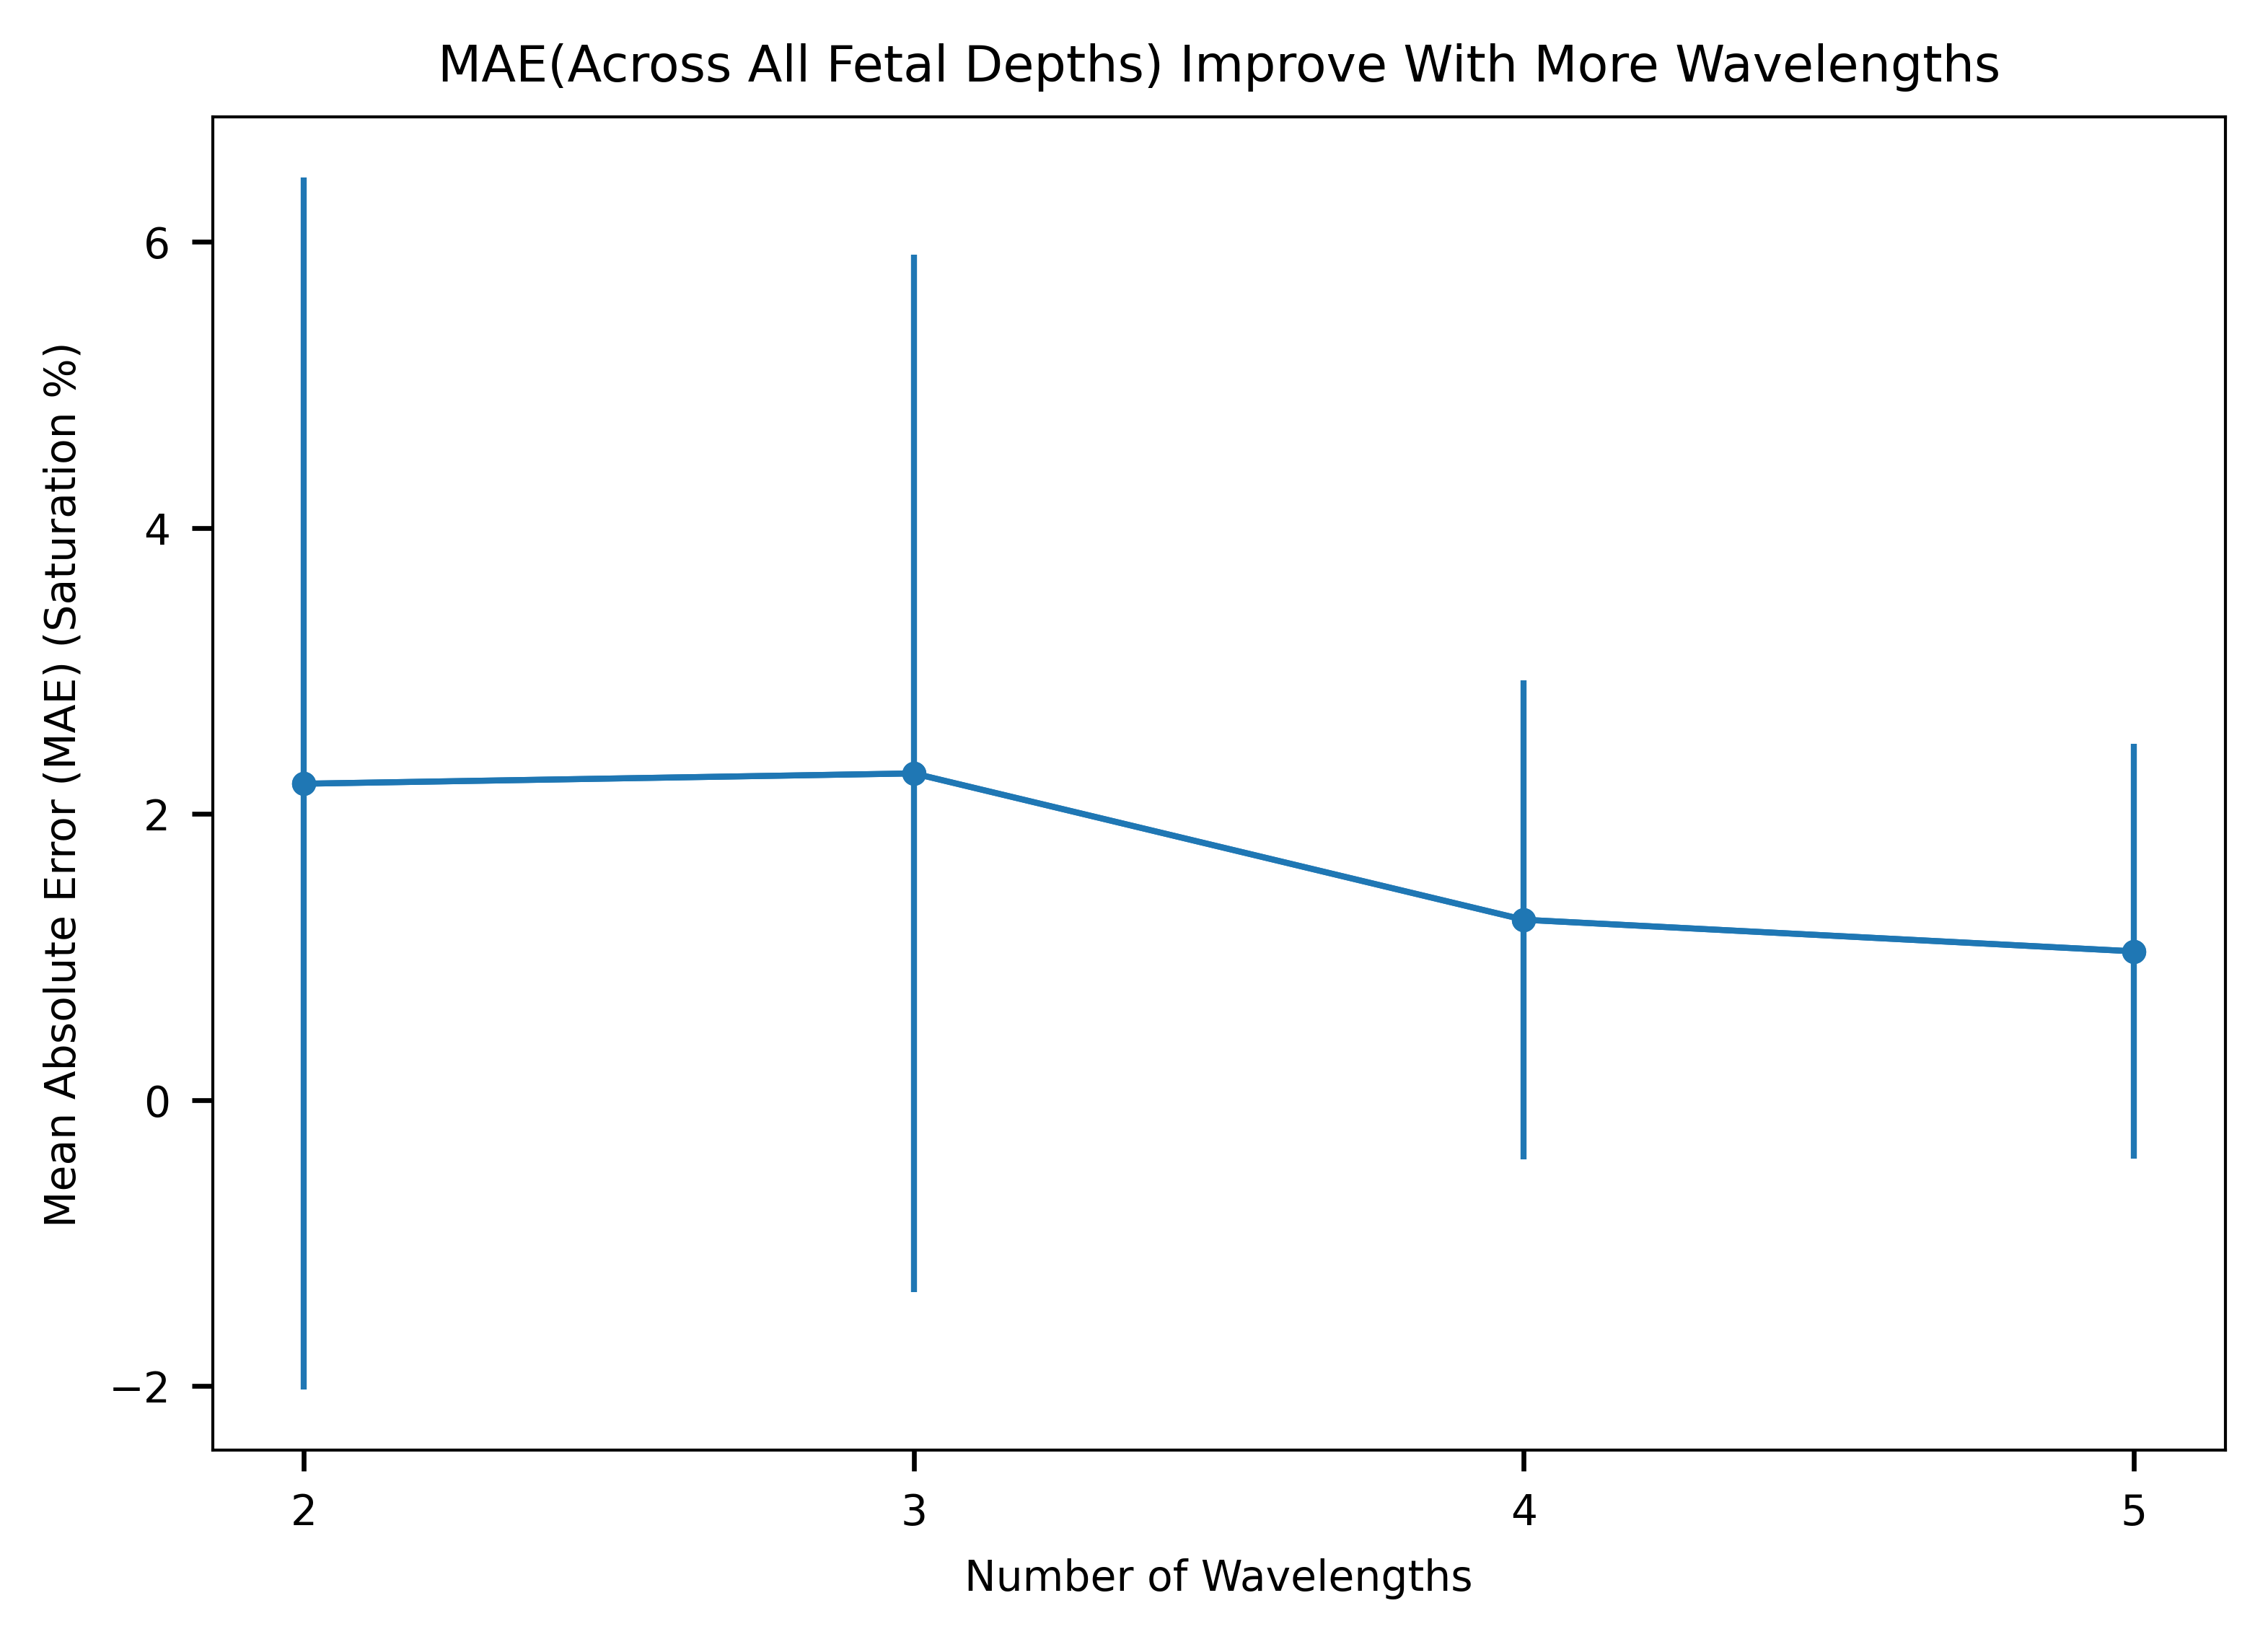

In [9]:
from matplotlib.ticker import MaxNLocator
## Plot the mean mae values vs. wavelength count
plt.figure(figsize=(6, 4), dpi=600)
plt.errorbar(
    [2, 3, 4, 5],
    [np.mean(mae) * 100 for mae in mae_value_matrix],
    yerr=[np.sqrt(np.mean(std**2)) * 100 for std in mae_std_matrix],    # Srd devs can only be added in squared form
    marker="o",
    color="tab:blue",
)  # Convert to percentage
plt.plot(
    [2, 3, 4, 5], [np.mean(mae) * 100 for mae in mae_value_matrix], marker="o", color="tab:blue"
)  # Convert to percentage
plt.xlabel("Number of Wavelengths")
plt.ylabel("Mean Absolute Error (MAE) (Saturation %)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("MAE(Across All Fetal Depths) Improve With More Wavelengths")

# Plotting (Alternate)


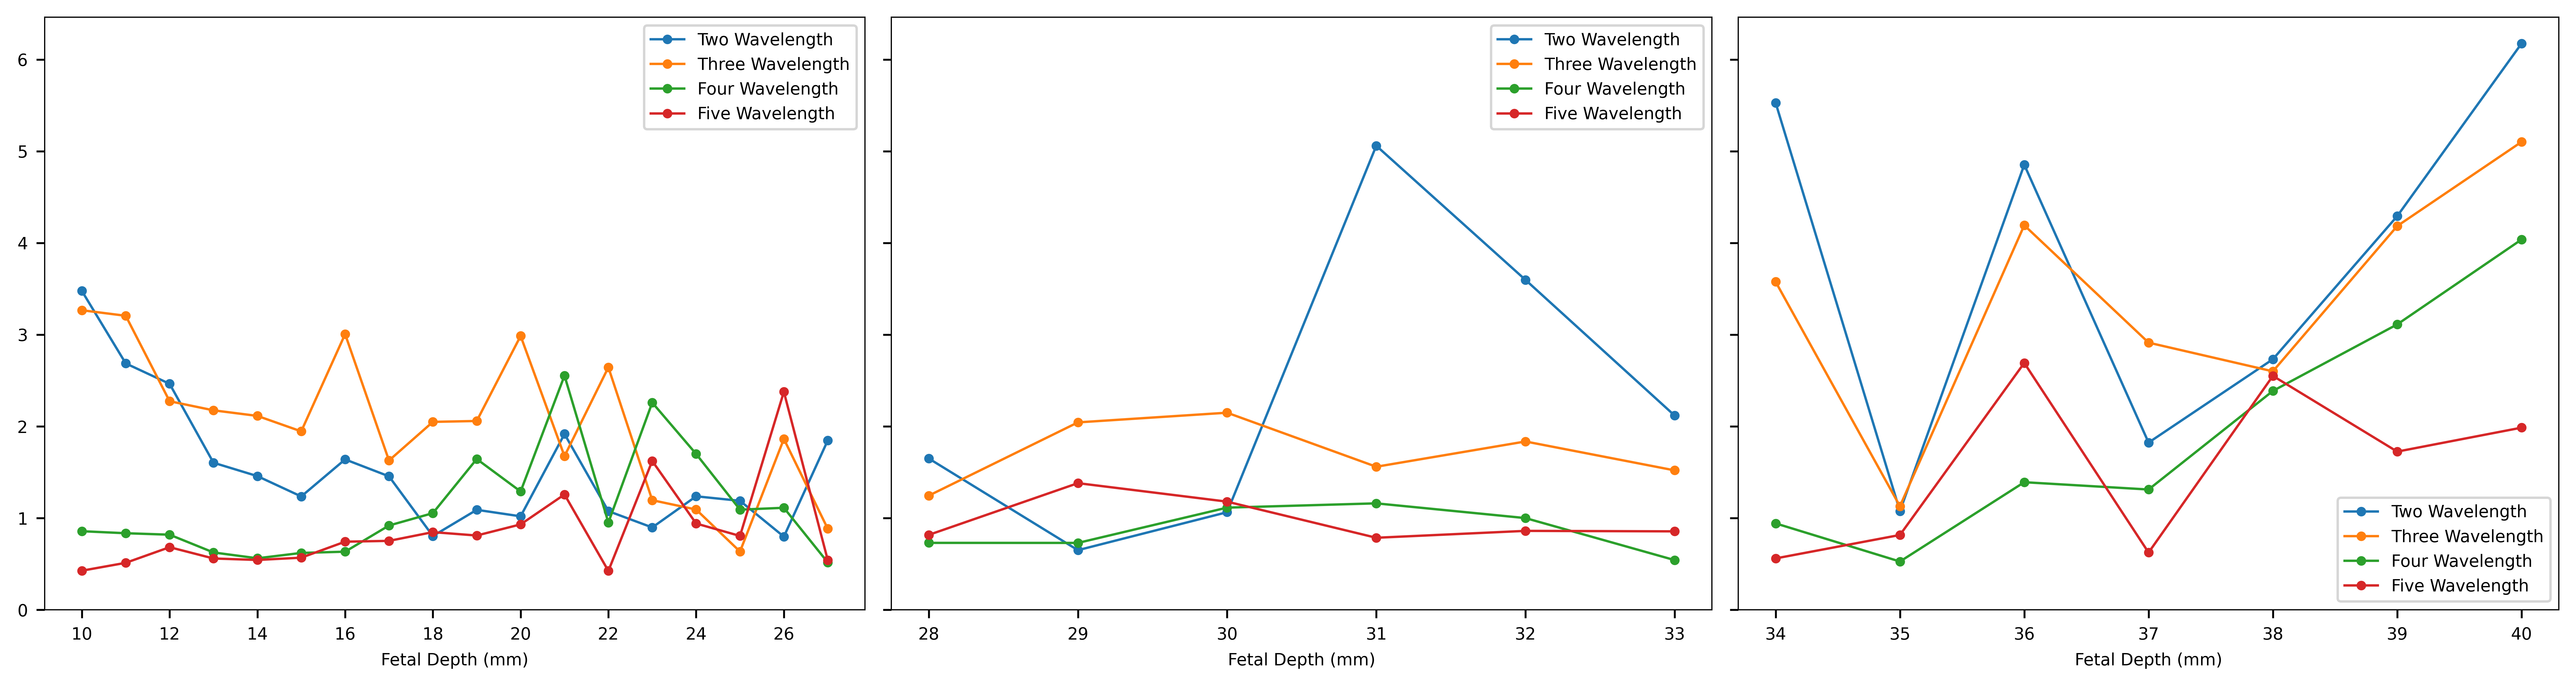

In [10]:
# Do the same matrix plotting as before but this time split into three subpltos
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=600, sharey=True)

# Make the x_axis always have integer tick values
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# I have 31 depths - split into 
split_indices = [slice(0, 18), slice(18, 24), slice(24, 31)]


for ax, split_index in zip(axes, split_indices):
    plt.sca(ax)
    for mae_values, mae_std, model_label in zip(mae_value_matrix, mae_std_matrix, model_labels):
        plt.plot(all_filter_values[split_index], mae_values[split_index] * 100, label=model_label, marker='o')    # Convert to percentage
    plt.xlabel("Fetal Depth (mm)")
    ax.legend()
# Make the lower limit 0
plt.ylim(bottom=0)
plt.tight_layout()